In [44]:
import xgboost
from clean_data import load_all_houses_with_device
import config_file
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
print(xgboost.__version__)

1.4.2


In [91]:
path = r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\input\1min_real_sept_oct_nov2019.csv"

In [92]:
homes_real = load_all_houses_with_device(config_file.path, 'refrigerator1')

In [93]:
X = np.array(homes_real['net_power'])

In [94]:
y = np.array(homes_real.appliance_power)

In [95]:
new_data_real = load_all_houses_with_device(r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\input\1min_real_dec2019.csv", 'refrigerator1')

In [111]:
new_data = np.array(new_data_real.loc[new_data_real.dataid==3488]['net_power'])

In [96]:
def autoregress_X(data, steps):
    lag = 0
    data = pd.DataFrame(data)
    for i in range(steps):
        lag += 1
        data[str("lag_"+str(lag))] = data[0][:len(data)-lag]
        data[str("lag_"+str(lag))] = data[str("lag_"+str(lag))].shift(lag)
    data = data.dropna(axis=0)
    data_new = data.copy(deep=True)
    return np.array(data_new)

In [97]:
def autoregress_y(data, steps):
    return np.array(data[steps:])

In [98]:
X_train = autoregress_X(X, 135)

<ipython-input-96-64fddafbbd51>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[str("lag_"+str(lag))] = data[0][:len(data)-lag]


In [99]:
# evaluate an xgboost regression model on the housing dataset
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
# load the dataset

model = XGBRegressor(booster='gbtree', learning_rate = 0.1, max_depth=10)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [100]:
# evaluate model
scores = cross_val_score(model, autoregress_X(X, 135), autoregress_y(y, 135), scoring='r2', cv=cv, n_jobs=None)
# force scores to be positive
scores = absolute(scores)
print('Mean R2: %.3f (%.3f)' % (scores.mean(), scores.std()) )

<ipython-input-96-64fddafbbd51>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[str("lag_"+str(lag))] = data[0][:len(data)-lag]


Mean R2: 0.337 (0.001)


In [101]:
model.fit(autoregress_X(X, 135), autoregress_y(y, 135))

<ipython-input-96-64fddafbbd51>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[str("lag_"+str(lag))] = data[0][:len(data)-lag]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=80, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [112]:
yhat = model.predict(autoregress_X(new_data, 135))

<ipython-input-96-64fddafbbd51>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[str("lag_"+str(lag))] = data[0][:len(data)-lag]


In [109]:
true = np.array(new_data_real.loc[new_data_real['dataid'] == 3488]['appliance_power'])

In [110]:
true = autoregress_y(true, 135)

In [102]:
new_data_real.dataid.unique()

array([  142,   145,   183,   335,   387,   526,   690,   950,   984,
        1240,  1249,  1417,  2126,  2358,  2561,  3344,  3383,  3488,
        3700,  3976,  3996,  4628,  5058,  5192,  5367,  5982,  6069,
        6178,  6240,  6526,  6564,  6594,  6672,  6703,  6907,  7021,
        7069,  7365,  7935,  8162,  8627,  8825,  8849,  9002,  9004,
        9053,  9290,  9973, 10164, 10182, 10554, 10811, 10983, 11421,
       11785, 11878], dtype=int64)

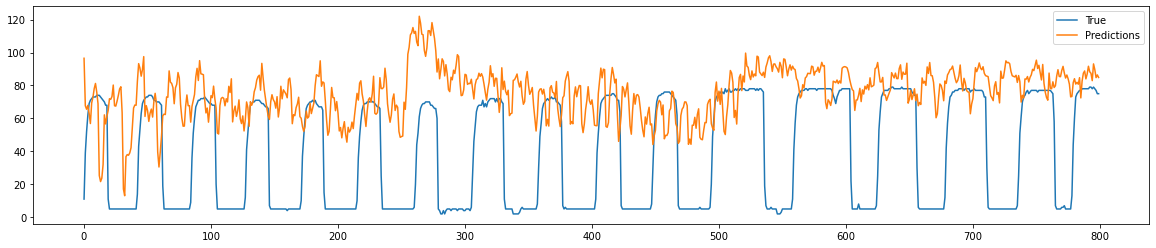

In [114]:
plt.figure(figsize=(20,4))
plt.plot(true[0:800])
plt.plot(yhat[0:800])

plt.legend(["True", "Predictions"])

In [123]:
def visualize_model(model, house, new_data_real, length):
    new_data = np.array(new_data_real.loc[new_data_real.dataid==house]['net_power'])
    yhat = model.predict(autoregress_X(new_data, 135))
    true = np.array(new_data_real.loc[new_data_real['dataid'] == house]['appliance_power'])
    true = autoregress_y(true, 135)
    plt.figure(figsize=(20,4))
    plt.plot(true[0:length])
    plt.plot(yhat[0:length])

    plt.legend(["True", "Predictions"])

<ipython-input-96-64fddafbbd51>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[str("lag_"+str(lag))] = data[0][:len(data)-lag]


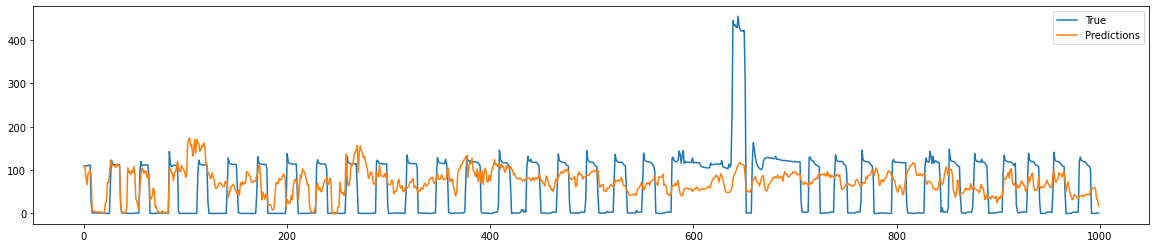

In [127]:
visualize_model(model, 335, new_data_real, 1000)

In [115]:
filename = r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\models\xg_boost_refrigerator_model_TRAIN_allhousesseptoctnov.sav"

In [116]:
pickle.dump(model, open(filename, 'wb'))

In [48]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(autoregress_X(new_data, 135), true)
print(result)

<ipython-input-9-64fddafbbd51>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[str("lag_"+str(lag))] = data[0][:len(data)-lag]


0.5514977719507919


In [83]:
import os, glob
import pandas as pd

In [87]:
path = r"C:\Users\aar245.CORNELL\Desktop\combine_data"

In [88]:
all_files = glob.glob(os.path.join(path, "*.csv"))

In [89]:
all_files

['C:\\Users\\aar245.CORNELL\\Desktop\\combine_data\\1min_real_sept2019.csv',
 'C:\\Users\\aar245.CORNELL\\Desktop\\combine_data\\2min_real_oct2019.csv',
 'C:\\Users\\aar245.CORNELL\\Desktop\\combine_data\\3min_real_nov2019.csv']

In [90]:
df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
df_merged = pd.concat(df_from_each_file, ignore_index=True)
df_merged.to_csv(r"C:\Users\aar245.CORNELL\Desktop\combine_data\1min_real_sept_oct_nov2019.csv")